<a href="https://colab.research.google.com/github/yoshiho0/AI-for-transportation/blob/main/Exercise7_Neural_Networks_2_ipynb_ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Network**
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

# **TASK 1: Develop the neural network model for predicting the count of rental bikes.​**
As experienced in regression exercise, the regression models did not perform well on the task of the count of rental bikes prediction. We look into the deep learing and This task will use the simple 2-layers fully connected neural network model as the example and guide you through the step-by-step process of the whole process of the model development.


## Load and prepare the data
Start by loading the dataset and shaping it so that it's suitable for use in machine learning. This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

In [29]:
import pandas as pd
from sympy.printing.tensorflow import tensorflow

# Define the URL from which to fetch the CSV data.
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_7_Neural_networks/Exercise7BikeSharing.csv'

# Use pandas to read the CSV data from the specified URL and store it in a DataFrame 'df'.
#df = pd.read_csv(url)
# Display the first 10 rows of the DataFrame 'df'.
df = pd.read_csv('Exercise7BikeSharing.csv')
df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


How many rows and columns does the dataset contain?

In [30]:
df.shape

(17379, 17)

Are any of the columns missing values?

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


## Feature engineering
- Target: `cnt` (count of total rental bikes including both casual and registered)
- Predictors: weather (`temp`, `atemp`, `hum`, `windspeed`, `weathersit`), calendar (`hr`, `weekday`, `workingday`, `holiday`, `season`), and `yr`.
- We keep it simple; you can expand features (e.g., interactions) later.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
target = 'cnt'
features = [
    'temp','atemp','hum','windspeed','weathersit',
    'hr','weekday','workingday','holiday','season','yr'
]

X = df[features].copy()
X['hr_workingday'] = df['hr'] * df['workingday']
X['weathersit_windspeed'] = df['windspeed'] * df['weathersit']
X['weathersit_season'] = df['season'] * df['weathersit']
y = df[target].astype(float)


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (important for NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**(Optional) quick baseline (Linear Regression)**

In [33]:
# A super-fast baseline, just for context
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
# rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print({"LR_RMSE": rmse_lr, "LR_MAE": mae_lr, "LR_R2": r2_lr})

{'LR_RMSE': np.float64(138.9062209264245), 'LR_MAE': 104.32926533779367, 'LR_R2': 0.39066200634361614}


## Create a neural network model
Now it's time build a neural network and train it with the data prepared in the previous exercise. We'll try neural network first and use cross-validation its meaasure accuracy.

In [ ]:
!pip install tensorflow

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create a Sequential model, which is a linear stack of layers.
model = Sequential()
# Add a Dense layer with 32 units, ReLU activation, and an input dimension of 11.
model.add(Dense(32, activation='relu', input_dim=14))
# Add another Dense layer with 64 units and ReLU activation.
model.add(Dense(64, activation='relu'))
# Add a final Dense layer with 1 unit (typically used for regression tasks).
model.add(Dense(1))
# Compile the model with the Adam optimizer, Mean Absolute Error (MAE) loss function,
# and MAE metric to be used during training.
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
# Display a summary of the model architecture, including the number of parameters.
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,657 (10.38 KB)

 Trainable params: 2,657 (10.38 KB)

 Non-trainable params: 0 (0.00 B)

## Training and prediction
We split the dataset into a training and a test dataset. Then, we fit the neural network model with the training dataset and predict the values for the test dataset.

Epoch 1/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 170.4708 - mae: 170.4708 - val_loss: 100.7921 - val_mae: 100.7921
Epoch 2/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 101.5500 - mae: 101.5500 - val_loss: 98.2479 - val_mae: 98.2479
Epoch 3/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 98.9154 - mae: 98.9154 - val_loss: 96.9138 - val_mae: 96.9138
Epoch 4/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 96.2651 - mae: 96.2651 - val_loss: 95.6248 - val_mae: 95.6248
Epoch 5/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 95.9579 - mae: 95.9579 - val_loss: 94.2607 - val_mae: 94.2607
Epoch 6/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 94.2635 - mae: 94.2635 - val_loss: 92.9301 - val_mae: 92.9301
Epoch 7/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 92.8871 - mae: 92.8871 - val_loss: 91.7523 - val_mae: 91.7523
Epoch 8/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 91.2793 - mae: 91.2793 - val_loss: 90.5741 - val_mae: 90.5741
Epoch 9/20

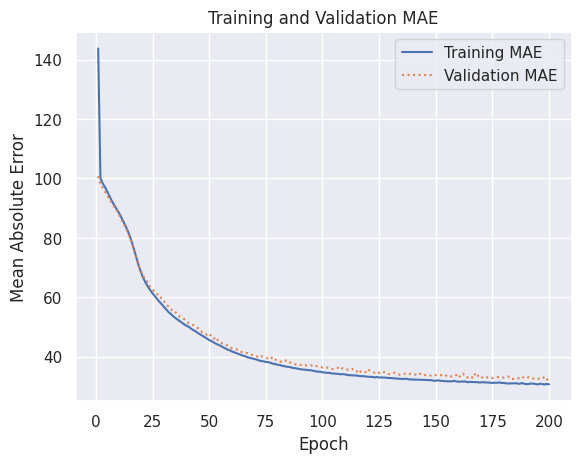

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Fit the model to the training data, specifying validation split, epochs, and batch size.
hist = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=200, batch_size=32)
# Set the style of the plots using Seaborn.
sns.set()
# Extract the training and validation Mean Absolute Error (MAE) from the training history.
err = hist.history['mae']
val_err = hist.history['val_mae']
# Define the number of epochs.
epochs = range(1, len(err) + 1)
# Plot the Training MAE and Validation MAE over epochs.
plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()
# Use the trained model to predict on the test data.
y_pred = model.predict(X_test_scaled)

## Evaluate the model
You can evaluate the model's performance using various metrics, such as Mean Absolute Error (MAE), Mean Squared Error (MSE), or R-squared (R2).

In [ ]:
import numpy as np

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the Mean Absolute Error (MAE) between the true and predicted values.
mae_nn = mean_absolute_error(y_test, y_pred)
# Calculate the Root Mean Squared Error (RMSE) between the true and predicted values.
mse_nn = mean_squared_error(y_test, y_pred)
# rmse_nn = mean_squared_error(y_test, y_pred, squared=False)
rmse_nn = np.sqrt(mse_nn)

# Calculate the R-squared (R2) score, a measure of how well the model explains the variance in the data.
r2_nn = r2_score(y_test, y_pred)
# Print the calculated metrics.
print(f"Mean Absolute Error of NN: {mae_nn}")
print(f"Root Mean Squared Error of NN: {rmse_nn}")
print(f"R-squared of NN: {r2_nn}")

Mean Absolute Error of NN: 32.13415938477762
Root Mean Squared Error of NN: 51.44573386003852
R-squared of NN: 0.9164178382438765


In [ ]:

print(sklearn.__version__)
help(mean_squared_error)

## Compare Metrics (optional)
we compare the performance of NN with baseline linear regression.

In [ ]:
import pandas as pd
results = pd.DataFrame([
    {'Model': 'Linear Regression', 'RMSE': rmse_lr, 'MAE': mae_lr, 'R2': r2_lr},
    {'Model': 'Neural Net', 'RMSE': rmse_nn, 'MAE': mae_nn, 'R2': r2_nn},
])
results

In [ ]:
# Bar chart of RMSE
plt.figure()
plt.bar(results['Model'], results['RMSE'])
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.show()

# **Task 2: Practical NN training techniques**
The task will illustrate some useful NN training techniques, including saving and loading the trained model, using the callback function to save the best model, and adding dropout layers.


In [ ]:
from json import load
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

#-------------------------------------------------data preprocessing------------------------------------------------------------------


#-------------------------------------------------network construction-----------------------------------------------------------------

#************************************************Here you can choose to add the dropout layer or not***************************
# #
# def construct_network_model():
#   # Create a Sequential model, which is a linear stack of layers.
#   model = Sequential()

#   # Add a Dense layer with 32 units, ReLU activation, and an input dimension of 4.
#   model.add(Dense(32, activation='relu', input_dim=4))

#   # # Add a Dropout layer with a dropout rate of 0.5.
#   # model.add(Dropout(0.5))

#   # Add another Dense layer with 64 units and ReLU activation.
#   model.add(Dense(64, activation='relu'))

#   # # Add another Dropout layer with a dropout rate of 0.5.
#   # model.add(Dropout(0.5))

#   # Add a final Dense layer with 1 unit (typically used for regression tasks).
#   model.add(Dense(1))
#   return model

# model=construct_network_model()
# # Compile the model with the Adam optimizer, Mean Absolute Error (MAE) loss function,
# # and MAE metric to be used during training.
# model.compile(optimizer='adam', loss='mae', metrics=['mae'])
#************************************************Here you can choose to add the dropout layer or not*****************

#-------------------------------------------------model train------------------------------------------------------------------
# use the callback function to early stop, learning rate ajusting, save the best model
# Create an EarlyStopping callback to monitor the validation mean absolute error (val_mae).
# It will stop training if val_mae doesn't improve for 5 consecutive epochs and restores the best weights.
early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

# Create a ReduceLROnPlateau callback to monitor val_mae.
# It reduces the learning rate by a factor of 0.5 if val_mae doesn't improve for 3 consecutive epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

# Define the file path where the best model will be saved.
filepath = "weights.best.keras"

# Create a ModelCheckpoint callback to monitor the validation mae (val_mae).
# The callback will save thhe model's weights only if the validation mae improves.
checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Train the model using the fit method.
hist_2 = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)


#-------------------------------------------------model evaluation--------------------------------------------------------------------

# Set the style of the plots using Seaborn.
sns.set()

# Extract the training and validation Mean Absolute Error (MAE) from the training history.
err = hist_2.history['mae']
val_err = hist_2.history['val_mae']

# Define the number of epochs.
epochs = range(1, len(err) + 1)

# Plot the Training MAE and Validation MAE over epochs.
plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

# Use the trained model to predict on the test data.
y_pred = model.predict(X_test_scaled)

# Calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) for the predictions.
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('--------------------------------------'+'this is result of the trained model'+"---------------------------------------------")
# Print the calculated metrics.
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

#-------------------------------------------------load model and evaluation--------------------------------------------------------------------
if not filepath =="":
  # Load a pre-trained model from the specified file path.
  model = load_model(filepath)

  # Use the loaded model to predict on the test data.
  y_pred = model.predict(X_test_scaled)

  # Calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) for the predictions.
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print('--------------------------------------'+'this is result of the model loaded from the local path'+"---------------------------------------------")

  # Print the calculated metrics.
  print(f"Mean Absolute Error: {mae}")
  print(f"Mean Squared Error: {mse}")
  print(f"R-squared: {r2}")



  # Create a scatter plot to visualize the relationship
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

  # Add labels and title
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("Actual vs. Predicted Values")

  # Add a diagonal line for reference (perfect predictions)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

  # Show the plot
  plt.show()


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 11, but received input with shape (None, 12)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 12), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

# **Task 3: Compare the results with a linear regression model**
The task involves comparing the results obtained from the neural network with those from the linear regression model, and we should analyze the reasons behind any differences in the outcomes.

In [ ]:
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Set the style of the plots using seaborn.
sns.set()

# Use the trained model to predict on the test data.
y_pred = model.predict(X_test_scaled)

# Calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) for the predictions.
mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('--------------------------------------'+'this is result of the neural network model'+"---------------------------------------------")
# Print the evaluation metrics.
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


# Create a Linear Regression model
model_linear = LinearRegression()
model_linear.fit(X_train_scaled, y_train)
y_pred_linear = model_linear.predict(X_test_scaled)

mae_linear = mean_absolute_error(y_test, y_pred_linear)
# rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print('--------------------------------------'+'this is result of the linear regression model'+"---------------------------------------------")
print(f"Mean Absolute Error of linear model: {mae_linear}")
print(f"Root Mean Squared Error of linear model: {rmse_linear}")
print(f"R-squared of linear model: {r2_linear}")

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 4, but received input with shape (32, 11)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 11), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

# **Assignment task: Find the best neural network model for the count of rental bikes prediction (assignment submission)**
Tuning the neural network models (e.g., dropout, sizing of the network), and finding the best neural network model. Suggestions:
- Try adding interaction features (e.g., `hr * workingday`, `weathersit * hum`).
- Tune NN hyperparameters (layers, neurons, learning rate) via `GridSearchCV`.
- Consider more advanced architectures (e.g., gradient boosting, LSTMs for temporal structure).